In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import seaborn
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5, select_from_rows
import dataset_parameters as params

# DATASET = 'akribian'
# DATASET = 'assistments_2009'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
DATASET = 'ednet'

INPUT_DIR = BASE_DIR + 'data/' + DATASET + '/raw/'
OUTPUT_DIR = BASE_DIR + 'data/' + DATASET + '/processed/sakt/'

TIME_STEPS = params.time_steps_dict[DATASET]

IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/sakt/' 
MODEL_PATH = BASE_DIR + 'models/sakt/' 

# Training parameters
BATCH_SIZE = 64
LATENT_DIM = 128 # latent dimension
PADDING = 0
SHUFFLE = True
TIME_STEPS = params.time_steps_dict[DATASET]
#EPOCHS = params.epochs_dict[DATASET]
EPOCHS = 200

# Depends on whether we're running exercise categories or exercise IDs
#NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_EXERCISES = params.exercise_id_dict[DATASET]

ROWS_PER_READ = 1000000

EARLY_STOPPING_TOLERANCE = 4
WEIGHT_DECAY = 1e-2
WARMUP = 8000
NUMBER_OF_HEADS = 8
DROPOUT = 0.2

# File paths
INPUT_PATH = IN_DATA_PATH + "processed.h5"

In [2]:
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


# Model class

In [3]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class sakt(nn.Module):  
    def __init__(self , ex_total , seq_len, dim, heads, dout ):
        super(sakt, self).__init__()
        self.seq_len = seq_len
        self.dim = dim
        embedding_dim = dim

        self.embd_in = nn.Embedding( 2*ex_total+1, embedding_dim  = embedding_dim )         # Interaction embedding
        self.embd_ex = nn.Embedding( ex_total+1 , embedding_dim = embedding_dim )       # Excercise embedding
        self.embd_pos = nn.Embedding( seq_len , embedding_dim = embedding_dim )

        self.linear = nn.ModuleList( [nn.Linear(in_features= embedding_dim , out_features= dim ) for x in range(3)] )   # Linear projection for each embedding
        self.attn = nn.MultiheadAttention(embed_dim= dim , num_heads= heads, dropout= dout )
        self.ffn = nn.ModuleList([nn.Linear(in_features= dim , out_features=dim, bias= True) for x in range(2)])  # feed forward layers post attention
        self.relu = nn.ReLU()  # feed forward layers post attention

        self.linear_out = nn.Linear(in_features= dim , out_features= 1 , bias=True)
        self.layer_norm1 = nn.LayerNorm( dim )
        self.layer_norm2 = nn.LayerNorm( dim )                           # output with correctnness prediction 
        self.drop = nn.Dropout(dout)

    def forward(self, input_in, input_ex, need_weights=False):

        padding_mask = input_ex == 0 # (batch, sequence). pytorch wants it in this format for some reason
        padding_mask = padding_mask.cuda()

        ## positional embedding
        #making a tensor of 12 numbers, .unsqueeze(0) for converting to 2d, so as to get a 3d output ##print('pos embd' , pos_in.shape)
        pos_in = self.embd_pos( torch.arange(self.seq_len).unsqueeze(0) )         

        ## get the interaction embedding output
        out_in = self.embd_in( input_in )                         
        out_in = out_in + pos_in

        ## split the interaction embeding into v and k ( needs to verify if it is slpited or not)
        value_in = out_in
        key_in   = out_in                                        
        
        ## get the excercise embedding output
        query_ex = self.embd_ex( input_ex )                      
        
        ## Linearly project all the embedings
        value_in = self.linear[0](value_in).permute(1,0,2)        # (b,n,d) --> (n,b,d)
        key_in = self.linear[1](key_in).permute(1,0,2)
        query_ex =  self.linear[2](query_ex).permute(1,0,2)

        # # Try a ReLU layer for 
        # value_in = self.relu(value_in)
        # key_in = self.relu(key_in)
        # query_ex = self.relu(query_ex)

        # # Or don't project embeddings...
        # value_in = value_in.permute(1,0,2)        # (b,n,d) --> (n,b,d)
        # key_in = key_in.permute(1,0,2)
        # query_ex =  query_ex.permute(1,0,2)

        ## pass through multihead attention
        atn_out, weights = self.attn(query_ex, 
                                key_in, value_in, 
                                attn_mask=torch.from_numpy( np.triu(np.ones((self.seq_len ,self.seq_len)), k=1).astype('bool')).cuda() # lower triangular mask, bool, torch (n,b,d)
                                ,key_padding_mask = padding_mask # padding mask 
                                )
        # Residual connection ; added excercise embd as residual because previous ex may have imp info, suggested in paper.
        atn_out = query_ex + atn_out                                  
        

        atn_out = self.layer_norm1( atn_out )                          # Layer norm    ##print('atn',atn_out.shape) #n,b,d = atn_out.shape

        #take batch on first axis 
        atn_out = atn_out.permute(1,0,2)                              #  (n,b,d) --> (b,n,d)
        
        ## FFN 2 layers
        ffn_out = self.drop(self.ffn[1]( self.relu( self.ffn[0]( atn_out ) )))   # (n,b,d) -->    .view([n*b ,d]) is not needed according to the kaggle implementation
        ffn_out = self.layer_norm2( ffn_out + atn_out )                # Layer norm and Residual connection

        ## sigmoid
        ffn_out = torch.sigmoid(self.linear_out( ffn_out )  )

        if need_weights:
            return ffn_out, weights
        else:
            return ffn_out


In [4]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Model training

In [5]:
## Training the model
print_freq = 10
graph_freq = 10

model = sakt( ex_total= NUMBER_OF_EXERCISES, seq_len= TIME_STEPS, dim= LATENT_DIM, heads= NUMBER_OF_HEADS, dout= DROPOUT )
model = model.cuda()
criterion = nn.BCELoss()
#optimizer = NoamOpt(model.dim, 1, WARMUP, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


losses_history = []

val_aucs = []

previous_auc = 0.0

no_improvement_streak = 0
best_auc = 0.0

with h5py.File(INPUT_PATH,'r') as h5_file:
  number_of_train_windows = h5_file['exercise_ids_train'].shape[0]
  number_of_val_windows = h5_file['exercises_val'].shape[0]

  for epoch in range(EPOCHS):
    print("Epoch %i" % (epoch+1))
    total_loss_print = 0.0
    total_loss_graph = 0.0

    for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

      exercises_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
      interactions_train = h5_file['interactions_train'][read_index:read_index+ROWS_PER_READ]
      labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]

      random_indices = np.arange(len(exercises_train))
      np.random.shuffle(random_indices)

      exercises_train = exercises_train[random_indices]
      interactions_train = interactions_train[random_indices]
      labels_train = labels_train[random_indices]

      for idx in range(0, len(exercises_train), BATCH_SIZE):
        # Retrieve data
        ex_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
        in_samples = torch.from_numpy(interactions_train[idx:idx + BATCH_SIZE]).long().cuda()
        label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).long().cuda()
        label = torch.unsqueeze(label, 2)

        # # print(torch.max(in_samples))
        # if torch.max(ex_samples.flatten()) > NUMBER_OF_EXERCISES:
        #   print("Bad exercise tag detected!")

        # # print(torch.max(in_samples))
        # if torch.max(in_samples.flatten()) > 2 * NUMBER_OF_EXERCISES:
        #   print("Bad interaction tag detected!")# print(torch.max(in_samples))

        # if torch.max(label.flatten()) > 1:
        #   print("Bad label detected!")

        # Reset optimizer
        optimizer.zero_grad()

        # Predict
        out = model(in_samples, ex_samples)
        # print("any nans in output?")
        # print(torch.any(torch.isnan(out)))

        # Calculate loss 
        loss = criterion(out, label.float())
        total_loss_print += loss.item()
        total_loss_graph += loss.item()

        # Optimize
        loss.backward()
        optimizer.step()

        idx_discrete = int(idx / BATCH_SIZE)

        # Print status
        if (idx_discrete % print_freq == print_freq - 1):
          avg_loss = total_loss_print/print_freq
          sys.stdout.write("\rIteration %i, avg loss %f" % (idx+1, avg_loss))
          sys.stdout.flush()
          total_loss_print = 0.0

        # Append to graph
        if (idx_discrete % graph_freq == graph_freq - 1):
          avg_loss = total_loss_graph/graph_freq
          losses_history.append(avg_loss)
          total_loss_graph = 0.0
            
    # Validation step
    # Set evaluation mode
    outs_preds = np.array([])
    val_labels_last = np.array([])
    model.eval()
    # Turn off grad calculation
    with torch.no_grad():
      # Iterate through val data
      for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
        exercises_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
        interactions_val = h5_file['interactions_val'][read_index:read_index+ROWS_PER_READ]
        labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
        for idx in range(0, len(exercises_val), BATCH_SIZE):
          ex_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
          in_samples_val = torch.from_numpy(interactions_val[idx:idx + BATCH_SIZE]).long().cuda()

          padding_mask = exercises_val[idx:idx + BATCH_SIZE] != 0

          label = labels_val[idx:idx + BATCH_SIZE]

          outs_pred = model(in_samples_val, ex_samples_val)
          outs_pred_np = outs_pred.cpu().detach().numpy().squeeze()
          outs_pred_indexed = outs_pred_np[padding_mask]
          outs_preds = np.append(outs_preds, outs_pred_indexed)

          label_indexed = label[padding_mask]
          val_labels_last = np.append(val_labels_last, label_indexed)

          # print(label_indexed)
          # print(outs_pred_indexed)
    # Revert to training mode
    model.train()

    # labels_val = h5_file['labels_val'][:].flatten()
    fpr, tpr, thresholds = roc_curve(val_labels_last, outs_preds)
    auc_score = auc(fpr, tpr)
    #auc_score = roc_auc_score(val_labels_last, outs_preds)
    val_aucs.append(auc_score)
    print("\nValidation AUC: %f" % auc_score)
    auc_diff = auc_score - previous_auc
    if epoch != 0:
      print("AUC difference: %f" % auc_diff)

    if auc_score <= best_auc:
      no_improvement_streak += 1
    else: 
      no_improvement_streak = 0
      best_auc = auc_score
      torch.save(model.state_dict(), MODEL_PATH + DATASET + ".torch")
      print("Model saved")

    if no_improvement_streak == EARLY_STOPPING_TOLERANCE:
      break

    previous_auc = auc_score


Epoch 1
Iteration 702017, avg loss 0.385810
Validation AUC: 0.750003
Model saved
Epoch 2
Iteration 702017, avg loss 0.385809
Validation AUC: 0.751440
AUC difference: 0.001437
Model saved
Epoch 3
Iteration 702017, avg loss 0.390454
Validation AUC: 0.752270
AUC difference: 0.000830
Model saved
Epoch 4
Iteration 702017, avg loss 0.391588
Validation AUC: 0.752827
AUC difference: 0.000556
Model saved
Epoch 5
Iteration 702017, avg loss 0.391127
Validation AUC: 0.752573
AUC difference: -0.000254
Epoch 6
Iteration 702017, avg loss 0.373037
Validation AUC: 0.753222
AUC difference: 0.000649
Model saved
Epoch 7
Iteration 136897, avg loss 0.373879

KeyboardInterrupt: 

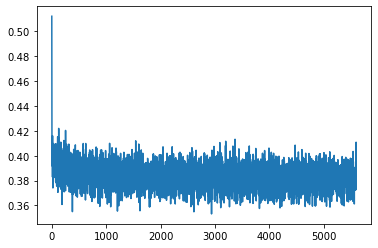

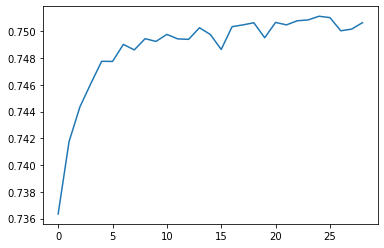

In [6]:
plt.figure(1)
plt.plot(losses_history)

plt.figure(2)
plt.plot(val_aucs)

In [7]:
# Load the best 
model.load_state_dict(torch.load(MODEL_PATH + DATASET + ".torch"))
model.eval()

outs_preds = np.array([])
test_labels_last = np.array([])

# predict iteratively in batches to avoid overloading VRAM
with h5py.File(INPUT_PATH,'r') as h5_file:
  number_of_test_windows = h5_file['exercise_ids_test'].shape[0]
  for read_index in range(0, number_of_test_windows, ROWS_PER_READ):
    exercises_test = h5_file['exercise_ids_test'][read_index:read_index+ROWS_PER_READ]
    interactions_test = h5_file['interactions_test'][read_index:read_index+ROWS_PER_READ]
    labels_test = h5_file['labels_test'][read_index:read_index+ROWS_PER_READ]
    for idx in range(0, len(exercises_test), BATCH_SIZE):
      ex_samples_test = torch.from_numpy(exercises_test[idx:idx + BATCH_SIZE]).long().cuda()
      in_samples_test = torch.from_numpy(interactions_test[idx:idx + BATCH_SIZE]).long().cuda()

      padding_mask = exercises_test[idx:idx + BATCH_SIZE] != 0

      label = labels_test[idx:idx + BATCH_SIZE]

      outs_pred = model(in_samples_test, ex_samples_test)
      outs_pred_np = outs_pred.cpu().detach().numpy().squeeze()
      outs_pred_indexed = outs_pred_np[padding_mask]
      outs_preds = np.append(outs_preds, outs_pred_indexed)

      label_indexed = label[padding_mask]
      test_labels_last = np.append(test_labels_last, label_indexed)

print(outs_preds.shape)
print(test_labels_last.shape)

(1332665,)
(1332665,)


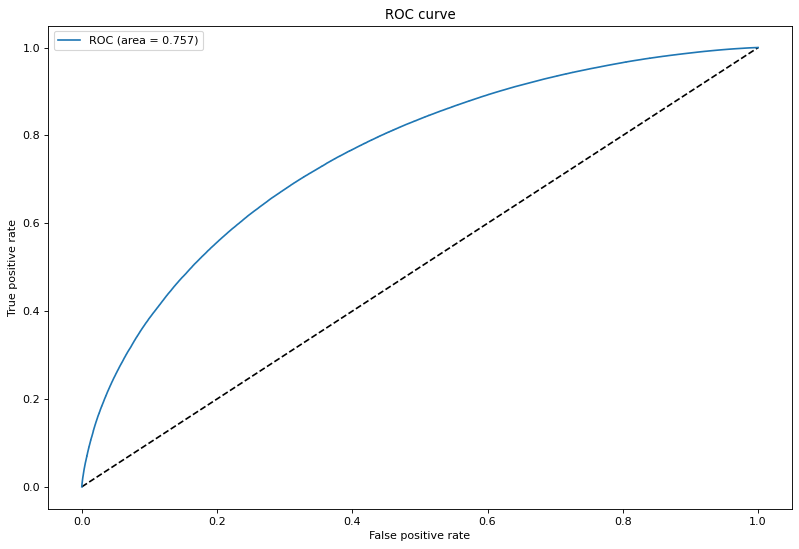

In [8]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_last, outs_preds)
auc_score = auc(fpr_keras, tpr_keras)
# This one reports too high auc...
#auc_score = roc_auc_score(test_labels_last, outs_preds)

plt.figure(3, figsize=(12,8), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

index index: 100


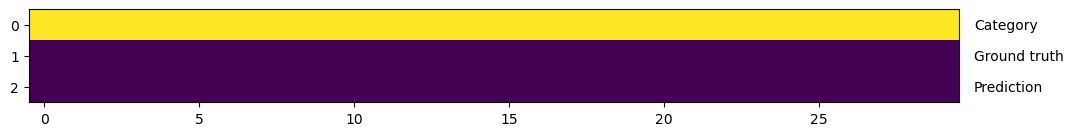

In [9]:
idx = 100
with h5py.File(INPUT_PATH,'r') as h5_file:
  ex_test = torch.from_numpy(h5_file['exercises_test'][idx:idx+1]).long().cuda()
  in_test = torch.from_numpy(h5_file['interactions_test'][idx:idx+1]).long().cuda()
  labels_test = torch.from_numpy(h5_file['labels_test'][idx:idx+1]).long().cuda()
  outs_pred, weights = model(in_test, ex_test, need_weights=True)

  img_width = TIME_STEPS
  max_width = 30

  ground_truth = labels_test.squeeze().cpu().detach().numpy()
  pred = outs_pred.squeeze().cpu().detach().numpy()


  # Define image
  img = np.ndarray((3, img_width))
  img = img[:, :max_width]

  # Set category color
  ex_color = ex_test.squeeze().cpu().detach().numpy()
  color_dict = dict(enumerate(list(set(ex_color))))
  color_dict = {v:k for k,v in color_dict.items()}
  colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
  colors = colors[-max_width:]
  img[0,:] = colors

  # Set ground truth color
  ground_truth = ground_truth[-max_width:]
  img[1,:] = ground_truth

  # Set prediction color
  pred = pred[-max_width:]
  img[2,:] = pred

  # Show the figure
  plt.figure(4, figsize=(12,8), dpi=100)
  plt.imshow(img)
  plt.text(max_width, 0.15, "Category")
  plt.text(max_width, 1.15, "Ground truth")
  plt.text(max_width, 2.15, "Prediction")

  # Index
  print("index index: %i" % idx)

<AxesSubplot:>

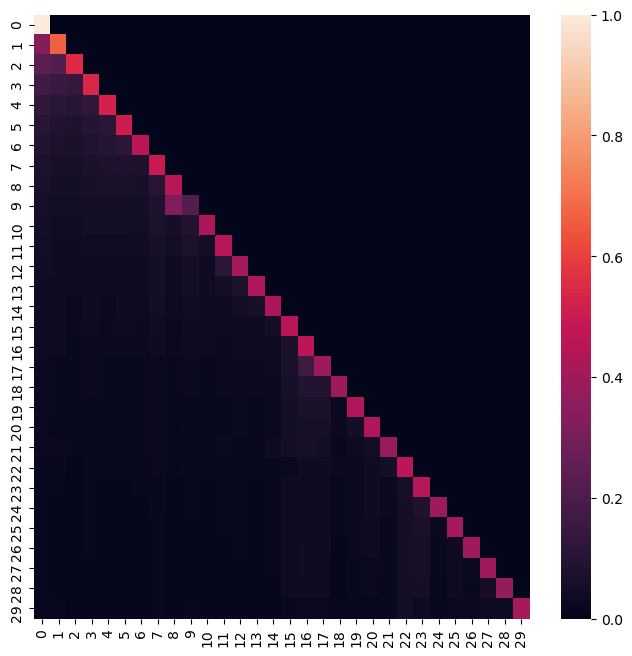

In [10]:
attention = weights.cpu().detach().numpy().squeeze()
plt.figure(5, figsize=(8,8), dpi=100)
seaborn.heatmap(attention[:max_width,:max_width])

In [11]:
idx = 100
with h5py.File(INPUT_PATH,'r') as h5_file:
    print(h5_file['exercises_train'][idx])
    print(h5_file['interactions_train'][idx])
    print(h5_file['labels_train'][idx])

[ 6  7  7  7 10 10  7 10 10 10  6 10 10 10 10 10 10 10  6 10 10 10  7 10
 10  6 10 10 10  6 10 10 10  6  2 10  7  7  6 10 10  6 10 10  2  7 10  2
  7  2  6 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  6  6 10 10  7
 10 10 10 10  6 10 10  7 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10  2 10  6  6 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  2 10 10 10
 10 10 10 10 10 10 10 10 10  7  7 10 10  6 10 10 10  7  7 10  7 10 10 10
 10 10  7 10 10  7 10  6 10  6  6  7 10 10 10 10 10  2  6  6 10 10 10 10
 10 10 10 10  6 10  6  7 10 10 10 10 10  6 10 10 10 10  6 10  7 10  6  6
 10 10 10 10 10 10  6 10 10 10 10 10 10  6 10 10  7 10 10  6 10 10 10  6
 10  6 10 10]
[10  6 18 18 18 21 21 18 21 21 21 17 21 21 21 21 21 21 21  6 10 10 10  7
 21 21 17 21 21 21 17 21 21 21 17 13 21  7  7  6 10 21 17 21 21  2 18 21
 13 18  2  6 10 21 21 21 21 21 21 21 21 21 21 21 21 21 21 10 17 17 21 21
 18 21 21 21 10  6 10 10 18 21 21 21 21 21 10 10 10 21 21 21 21 21 21 21
 21 21 13 21 17 17 21 10 10 10 10 10 